# Job Shop Scheduling Problem (JSSP) - Branch and Bound Low Cost

## Introducción

El **Job Shop Scheduling Problem (JSSP)** es un problema clásico de optimización combinatoria donde tenemos:

- **n jobs** (trabajos) que deben procesarse
- **m máquinas** disponibles
- Cada job tiene una secuencia de operaciones que deben ejecutarse en un orden específico
- Cada operación requiere una máquina específica y tiene una duración determinada

### Objetivo
Minimizar el **makespan** (tiempo total de finalización de todos los jobs)

### Restricciones
1. Cada máquina puede procesar solo una operación a la vez
2. Las operaciones de un job deben ejecutarse en orden
3. Una vez iniciada, una operación no puede interrumpirse

### Aplicaciones
- Manufactura
- Logística
- Planificación de proyectos
- Sistemas de producción


## Instalación de Dependencias
Instalación de dependencias requeridas para el experimento


In [19]:
# Install required packages
%pip install numpy matplotlib plotly pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importación de Librerías


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import time
from typing import List, Tuple, Dict, Optional
from collections import deque
import heapq
import copy
import pandas as pd


## Representación del Problema JSSP

Un problema JSSP se representa mediante una matriz donde:
- Cada fila representa un **job**
- Cada columna representa una **operación** en secuencia
- Cada celda contiene: **(máquina, tiempo_procesamiento)**

### Ejemplo:
```python
# 3 jobs, 3 máquinas
problema = [
    [(0, 3), (1, 2), (2, 2)],  # Job 0: M0(3) -> M1(2) -> M2(2)
    [(0, 2), (2, 1), (1, 4)],  # Job 1: M0(2) -> M2(1) -> M1(4)
    [(1, 4), (2, 3)],          # Job 2: M1(4) -> M2(3)
]
```


In [21]:
# Definición de instancias de prueba del JSSP

# Problema test 2 jobs, 2 máquinas
problema_test = [
    [(0, 3), (1, 2)],  # Job 0
    [(1, 2), (0, 4)],  # Job 1
]

# Problema pequeño: 3 jobs, 3 máquinas
problema_3x3 = [
    [(0, 3), (1, 2), (2, 2)],  # Job 0
    [(0, 2), (2, 1), (1, 4)],  # Job 1
    [(1, 4), (2, 3), (0, 1)],  # Job 2
]

# Problema mediano: 4 jobs, 3 máquinas
problema_4x3 = [
    [(0, 2), (1, 3), (2, 1)],  # Job 0
    [(1, 2), (0, 4), (2, 2)],  # Job 1
    [(2, 3), (0, 1), (1, 2)],  # Job 2
    [(0, 2), (2, 2), (1, 3)],  # Job 3
]

print("✓ Instancias de prueba definidas")
print(f"  - Problema 3x3: {len(problema_3x3)} jobs, {len(problema_3x3[0])} operaciones por job")
print(f"  - Problema 4x3: {len(problema_4x3)} jobs, {len(problema_4x3[0])} operaciones por job")


✓ Instancias de prueba definidas
  - Problema 3x3: 3 jobs, 3 operaciones por job
  - Problema 4x3: 4 jobs, 3 operaciones por job


## Representación de Soluciones

Una solución al JSSP se representa como una **lista de tuplas** donde cada tupla contiene:
- `(job_id, operacion_id, maquina_id, tiempo_inicio, tiempo_fin)`

Esta representación permite visualizar fácilmente el diagrama de Gantt.


## Funciones Auxiliares para JSSP


In [22]:
class EstadoJSSP:
    """Representa el estado de una solución parcial del JSSP.
    
    Atributos:
        problema: Instancia del JSSP
        siguiente_operacion: Array que indica la siguiente operación a procesar de cada job
        tiempo_finalizacion_job: Tiempo de finalización de la última operación de cada job
        tiempo_finalizacion_maquina: Tiempo de finalización de la última operación en cada máquina
        operaciones_programadas: Lista de operaciones ya programadas (job, op, maq, inicio, fin)
        cota_inferior: Cota inferior estimada para este estado
    """
    
    def __init__(self, problema: List[List[Tuple[int, int]]]):
        self.problema = problema
        self.num_jobs = len(problema)
        self.num_maquinas = max(max(maq for maq, _ in job) for job in problema) + 1
        
        # Estado inicial: ninguna operación programada
        self.siguiente_operacion = [0] * self.num_jobs  # Siguiente operación de cada job
        self.tiempo_finalizacion_job = [0] * self.num_jobs  # Cuándo termina el último trabajo de cada job
        self.tiempo_finalizacion_maquina = [0] * self.num_maquinas  # Cuándo queda libre cada máquina
        self.operaciones_programadas = []  # Lista de (job, op_idx, maq, inicio, fin)
        self.cota_inferior = 0
    
    def es_completo(self) -> bool:
        """Verifica si todas las operaciones han sido programadas."""
        return all(self.siguiente_operacion[j] == len(self.problema[j]) 
                  for j in range(self.num_jobs))
    
    def obtener_makespan(self) -> int:
        """Retorna el makespan (tiempo total) de la solución actual."""
        if not self.operaciones_programadas:
            return 0
        return max(fin for _, _, _, _, fin in self.operaciones_programadas)
    
    def copiar(self):
        """Crea una copia profunda del estado."""
        nuevo = EstadoJSSP(self.problema)
        nuevo.siguiente_operacion = self.siguiente_operacion.copy()
        nuevo.tiempo_finalizacion_job = self.tiempo_finalizacion_job.copy()
        nuevo.tiempo_finalizacion_maquina = self.tiempo_finalizacion_maquina.copy()
        nuevo.operaciones_programadas = self.operaciones_programadas.copy()
        nuevo.cota_inferior = self.cota_inferior
        return nuevo
    
    def programar_operacion(self, job_id: int) -> 'EstadoJSSP':
        """Programa la siguiente operación del job indicado y retorna un nuevo estado.
        
        Args:
            job_id: ID del job cuya siguiente operación se va a programar
            
        Returns:
            Nuevo estado con la operación programada
        """
        # Crear nuevo estado
        nuevo_estado = self.copiar()
        
        # Obtener información de la operación
        op_idx = self.siguiente_operacion[job_id]
        maquina, duracion = self.problema[job_id][op_idx]
        
        # Calcular tiempo de inicio (debe esperar a que termine la operación anterior del job
        # Y a que la máquina esté libre)
        tiempo_inicio = max(
            self.tiempo_finalizacion_job[job_id],
            self.tiempo_finalizacion_maquina[maquina]
        )
        tiempo_fin = tiempo_inicio + duracion
        
        # Actualizar estado
        nuevo_estado.siguiente_operacion[job_id] += 1
        nuevo_estado.tiempo_finalizacion_job[job_id] = tiempo_fin
        nuevo_estado.tiempo_finalizacion_maquina[maquina] = tiempo_fin
        nuevo_estado.operaciones_programadas.append(
            (job_id, op_idx, maquina, tiempo_inicio, tiempo_fin)
        )
        
        return nuevo_estado
    
    def obtener_jobs_disponibles(self) -> List[int]:
        """Retorna la lista de jobs que tienen operaciones pendientes."""
        return [j for j in range(self.num_jobs) 
                if self.siguiente_operacion[j] < len(self.problema[j])]
    
    def __lt__(self, other):
        """Comparación para el heap (menor cota inferior = mayor prioridad)."""
        return self.cota_inferior < other.cota_inferior
    def __repr__(self):
        return (f"EstadoJSSP(cota_inferior={self.cota_inferior})," f"siguientes operaciones={self.operaciones_programadas}", f"es_completo={self.es_completo()})", f"makespan={self.obtener_makespan()})") 

print("✓ Clase EstadoJSSP definida")


✓ Clase EstadoJSSP definida


In [23]:
def calcular_cota_inferior_por_carga_restante(estado: EstadoJSSP) -> int:
    """Calcula cota inferior trivial basada en la carga de trabajo restante.
    
    Cota 1: Para cada job, suma el tiempo ya transcurrido más todas sus operaciones pendientes.
    Cota 2: Para cada máquina, suma el tiempo ya usado más todas las operaciones pendientes en esa máquina.
    
    La cota inferior es el máximo entre ambas.
    
    Args:
        estado: Estado actual del JSSP
        
    Returns:
        Cota inferior del makespan
    """
    cota_por_jobs = 0
    for job_id in range(estado.num_jobs):
        tiempo_job = estado.tiempo_finalizacion_job[job_id]

        for op_idx in range(estado.siguiente_operacion[job_id], len(estado.problema[job_id])):
            _, duracion = estado.problema[job_id][op_idx]
            tiempo_job += duracion
        cota_por_jobs = max(cota_por_jobs, tiempo_job)
    
    cota_por_maquinas = 0
    for maquina_id in range(estado.num_maquinas):
        tiempo_maquina = estado.tiempo_finalizacion_maquina[maquina_id]

        for job_id in range(estado.num_jobs):
            for op_idx in range(estado.siguiente_operacion[job_id], len(estado.problema[job_id])):
                maquina, duracion = estado.problema[job_id][op_idx]
                if maquina == maquina_id:
                    tiempo_maquina += duracion
        cota_por_maquinas = max(cota_por_maquinas, tiempo_maquina)

    return max(cota_por_jobs, cota_por_maquinas)


def calcular_cota_inferior_por_relajacion_lineal(estado: EstadoJSSP) -> int:
    """Calcula cota inferior usando relajación lineal.
    
    Ignora las restricciones de precedencia entre operaciones de un mismo job,
    permitiendo que se ejecuten en paralelo. Esto da una cota más ajustada.
    
    Args:
        estado: Estado actual del JSSP
        
    Returns:
        Cota inferior del makespan
    """
    cota_base = calcular_cota_inferior_por_carga_restante(estado)
    carga_por_maquina = estado.tiempo_finalizacion_maquina.copy()
    
    for job_id in range(estado.num_jobs):
        for op_idx in range(estado.siguiente_operacion[job_id], len(estado.problema[job_id])):
            maquina, duracion = estado.problema[job_id][op_idx]
            carga_por_maquina[maquina] += duracion
    
    cota_maquinas = max(carga_por_maquina)
    
    return max(cota_base, cota_maquinas)


def calcular_cota_inferior_por_maquinas_independientes(estado: EstadoJSSP) -> int:
    """Calcula cota inferior usando relajación de máquinas independientes.
    
    Asume que cada job puede ser procesado por cualquier máquina de manera independiente,
    ignorando las restricciones de máquina específica. Esto proporciona una cota
    aún más ajustada que considera la distribución óptima de carga.
    
    Args:
        estado: Estado actual del JSSP
        
    Returns:
        Cota inferior del makespan
    """
    cota_base = calcular_cota_inferior_por_relajacion_lineal(estado)
    
    carga_total_restante = 0
    for job_id in range(estado.num_jobs):
        for op_idx in range(estado.siguiente_operacion[job_id], len(estado.problema[job_id])):
            _, duracion = estado.problema[job_id][op_idx]
            carga_total_restante += duracion

    tiempo_max_actual = max(estado.tiempo_finalizacion_maquina) if estado.tiempo_finalizacion_maquina else 0
    
    cota_distribucion = tiempo_max_actual + (carga_total_restante / estado.num_maquinas)
    
    return max(cota_base, int(np.ceil(cota_distribucion)))

def generar_solucion_inicial_simple(problema: List[List[Tuple[int, int]]]) -> Tuple[int, EstadoJSSP]:
    """Genera una solución inicial simple programando jobs en orden secuencial.
    
    Esta función reemplaza a las heurísticas greedy y se usa solo para obtener
    una cota superior inicial en Branch and Bound.
    
    Args:
        problema: Instancia del JSSP
        
    Returns:
        Tupla (makespan, estado_final)
    """
    estado = EstadoJSSP(problema)
    
    while not estado.es_completo():
        jobs_disponibles = estado.obtener_jobs_disponibles()
        if jobs_disponibles:
            # Seleccionar el primer job disponible
            job_seleccionado = jobs_disponibles[0]
            estado = estado.programar_operacion(job_seleccionado)
    
    return estado.obtener_makespan(), estado


print("✓ Funciones de cotas definidas:")
print("  - calcular_cota_inferior_por_carga_restante: Cota trivial por carga")
print("  - calcular_cota_inferior_por_relajacion_lineal: Relajación lineal")
print("  - calcular_cota_inferior_por_maquinas_independientes: Relajación de máquinas")


✓ Funciones de cotas definidas:
  - calcular_cota_inferior_por_carga_restante: Cota trivial por carga
  - calcular_cota_inferior_por_relajacion_lineal: Relajación lineal
  - calcular_cota_inferior_por_maquinas_independientes: Relajación de máquinas


## Branch and Bound - Estrategias de Búsqueda

### Concepto
Branch and Bound es un algoritmo exacto que explora el espacio de soluciones de forma sistemática, usando cotas para podar ramas que no pueden conducir a la solución óptima.

### Tres Estrategias Principales

#### 1. Low Cost (Best First Search)
- **Estructura**: Cola de prioridad (heap)
- **Criterio**: Expande el nodo con **menor cota inferior**
- **Ventaja**: Explora primero las ramas más prometedoras
- **Desventaja**: Mayor overhead por mantener el heap

#### 2. LIFO (Last In First Out - DFS)
- **Estructura**: Pila
- **Criterio**: Expande el **último nodo agregado** (profundidad primero)
- **Ventaja**: Encuentra rápidamente una solución completa, bajo uso de memoria
- **Desventaja**: Puede explorar ramas no prometedoras por más tiempo

#### 3. FIFO (First In First Out - BFS)
- **Estructura**: Cola
- **Criterio**: Expande el **primer nodo agregado** (amplitud primero)
- **Ventaja**: Explora sistemáticamente por niveles
- **Desventaja**: Puede requerir mucha memoria en problemas grandes

### Algoritmo General:
1. Inicializar con estado vacío
2. Calcular cota superior inicial (solución greedy)
3. Mientras haya nodos en la estructura:
   - Extraer nodo según estrategia (heap/pila/cola)
   - Si la cota inferior ≥ cota superior: podar
   - Si es solución completa: actualizar mejor solución
   - Si no: generar hijos y agregarlos a la estructura

### Comparación
Todas las estrategias encuentran el **óptimo**, pero difieren en:
- **Número de nodos explorados**
- **Eficiencia de poda**
- **Tiempo de ejecución**
- **Uso de memoria**


In [24]:
#Defino maximo de nodos:
LIMIT = 2_000_000
class BranchAndBoundLowCost:
    """Implementación de Branch and Bound con estrategia Low Cost para JSSP.
    
    La estrategia Low Cost expande siempre el nodo con menor cota inferior,
    usando una cola de prioridad (heap).
    """
    
    def __init__(self, problema: List[List[Tuple[int, int]]], verbose: bool = False, 
                 tipo_cota: str = "maquinas_independientes", limite_nodos = LIMIT):
        """Inicializa el solver.
        
        Args:
            problema: Instancia del JSSP
            verbose: Si True, imprime información de progreso
            tipo_cota: Tipo de cota a usar ("carga_restante", "relajacion_lineal", "maquinas_independientes")
        """
        self.problema = problema
        self.verbose = verbose
        self.tipo_cota = tipo_cota
        self.limites_nodos = limite_nodos
        
        # Seleccionar función de cota
        if tipo_cota == "carga_restante":
            self.funcion_cota_inferior = calcular_cota_inferior_por_carga_restante
        elif tipo_cota == "relajacion_lineal":
            self.funcion_cota_inferior = calcular_cota_inferior_por_relajacion_lineal
        else:  # maquinas_independientes
            self.funcion_cota_inferior = calcular_cota_inferior_por_maquinas_independientes
        
        # Estadísticas
        self.nodos_explorados = 0
        self.nodos_podados = 0
        self.tiempo_ejecucion = 0
        
        # Mejor solución encontrada
        self.mejor_makespan = float('inf')
        self.mejor_solucion = None
    
    def resolver(self) -> Tuple[int, EstadoJSSP]:
        """Resuelve el JSSP usando Branch and Bound Low Cost.
        
        Returns:
            Tupla (makespan_optimo, estado_optimo)
        """
        tiempo_inicio = time.time()
        
        # Inicializar con estado vacío
        estado_inicial = EstadoJSSP(self.problema)
        estado_inicial.cota_inferior = self.funcion_cota_inferior(estado_inicial)
        
        # Calcular cota superior inicial con solución simple
        makespan_inicial, solucion_inicial = generar_solucion_inicial_simple(self.problema)
        self.mejor_makespan = makespan_inicial
        self.mejor_solucion = solucion_inicial

        
        if self.verbose:
            print(f"Cota superior inicial: {self.mejor_makespan}")
        
        # Cola de prioridad: heap de estados ordenados por cota inferior
        heap = [estado_inicial]
        
        # Branch and Bound
        while heap:
            # Extraer estado con menor cota inferior (Low Cost)
            estado_actual = heapq.heappop(heap)
            self.nodos_explorados += 1
            
            #Condición para evitar loops infinitos
            if self.nodos_explorados >= self.limites_nodos:
                if self.verbose:
                    print("Límite de nodos explorados alcanzado, terminando búsqueda.")
                break

            # Poda por cota: si la cota inferior es mayor o igual a la mejor solución, podar
            if estado_actual.cota_inferior >= self.mejor_makespan:
                self.nodos_podados += 1
                continue
            
            # Si es solución completa, actualizar mejor solución
            if estado_actual.es_completo():
                makespan = estado_actual.obtener_makespan()
                if makespan < self.mejor_makespan:
                    self.mejor_makespan = makespan
                    self.mejor_solucion = estado_actual
                    if self.verbose:
                        print(f"Nueva mejor solución: {self.mejor_makespan} (nodos: {self.nodos_explorados})")
                continue
            
            # Generar hijos: programar cada operación disponible
            jobs_disponibles = estado_actual.obtener_jobs_disponibles()
            
            for job_id in jobs_disponibles:
                # Crear nuevo estado programando la operación del job
                nuevo_estado = estado_actual.programar_operacion(job_id)
                
                # Calcular cota inferior del nuevo estado
                nuevo_estado.cota_inferior = self.funcion_cota_inferior(nuevo_estado)
                
                # Solo agregar si la cota inferior es mejor que la mejor solución
                if nuevo_estado.cota_inferior < self.mejor_makespan:
                    heapq.heappush(heap, nuevo_estado)
                else:
                    self.nodos_podados += 1
        
        self.tiempo_ejecucion = time.time() - tiempo_inicio
        
        if self.verbose:
            print(f"\n=== Estadísticas ===")
            print(f"Makespan óptimo: {self.mejor_makespan}")
            print(f"Nodos explorados: {self.nodos_explorados}")
            print(f"Nodos podados: {self.nodos_podados}")
            print(f"Tiempo: {self.tiempo_ejecucion:.4f}s")
        
        return self.mejor_makespan, self.mejor_solucion


class BranchAndBoundLIFO:
    """Implementación de Branch and Bound con estrategia LIFO (DFS) para JSSP.
    
    La estrategia LIFO expande el último nodo agregado (Depth First Search),
    usando una pila (lista).
    """
    
    def __init__(self, problema: List[List[Tuple[int, int]]], verbose: bool = False,
                 tipo_cota: str = "maquinas_independientes", limite_nodos = LIMIT):
        self.problema = problema
        self.verbose = verbose
        self.limites_nodos = limite_nodos
        
        # Seleccionar función de cota
        if tipo_cota == "carga_restante":
            self.funcion_cota_inferior = calcular_cota_inferior_por_carga_restante
        elif tipo_cota == "relajacion_lineal":
            self.funcion_cota_inferior = calcular_cota_inferior_por_relajacion_lineal
        else:
            self.funcion_cota_inferior = calcular_cota_inferior_por_maquinas_independientes
        
        self.nodos_explorados = 0
        self.nodos_podados = 0
        self.tiempo_ejecucion = 0
        self.mejor_makespan = float('inf')
        self.mejor_solucion = None
    
    def resolver(self) -> Tuple[int, EstadoJSSP]:
        """Resuelve el JSSP usando Branch and Bound LIFO (DFS).
        
        Returns:
            Tupla (makespan_optimo, estado_optimo)
        """
        tiempo_inicio = time.time()
        
        estado_inicial = EstadoJSSP(self.problema)
        estado_inicial.cota_inferior = self.funcion_cota_inferior(estado_inicial)
        
        # Cota superior inicial
        makespan_inicial, solucion_inicial = generar_solucion_inicial_simple(self.problema)
        self.mejor_makespan = makespan_inicial
        self.mejor_solucion = solucion_inicial
        if self.verbose:
            print(f"Cota superior inicial: {self.mejor_makespan}")
        
        self.funcion_cota_inferior(self.mejor_solucion)
        # Pila para LIFO (último en entrar, primero en salir)
        pila = [estado_inicial]
        
        while pila:
            # Extraer el último elemento (LIFO - DFS)
            estado_actual = pila.pop()
            self.nodos_explorados += 1
            #Condición para evitar loops infinitos
            if self.nodos_explorados >= self.limites_nodos:
                if self.verbose:
                    print("Límite de nodos explorados alcanzado, terminando búsqueda.")
                break
            # Poda por cota
            if estado_actual.cota_inferior >= self.mejor_makespan:
                print("PODADO")
                self.nodos_podados += 1
                continue
            
            # Si es solución completa
            if estado_actual.es_completo():
                makespan = estado_actual.obtener_makespan()
                if makespan < self.mejor_makespan:
                    self.mejor_makespan = makespan
                    self.mejor_solucion = estado_actual
                    if self.verbose:
                        print(f"Nueva mejor solución: {self.mejor_makespan} (nodos: {self.nodos_explorados})")
                continue
            
            # Generar hijos
            jobs_disponibles = estado_actual.obtener_jobs_disponibles()
            
            for job_id in jobs_disponibles:
                nuevo_estado = estado_actual.programar_operacion(job_id)
                nuevo_estado.cota_inferior = self.funcion_cota_inferior(nuevo_estado)
                
                if nuevo_estado.cota_inferior < self.mejor_makespan:
                    pila.append(nuevo_estado)  # Agregar al final (LIFO)
                else:
                    self.nodos_podados += 1
        
        self.tiempo_ejecucion = time.time() - tiempo_inicio
        
        if self.verbose:
            print(f"\n=== Estadísticas ===")
            print(f"Makespan óptimo: {self.mejor_makespan}")
            print(f"Nodos explorados: {self.nodos_explorados}")
            print(f"Nodos podados: {self.nodos_podados}")
            print(f"Tiempo: {self.tiempo_ejecucion:.4f}s")
        
        return self.mejor_makespan, self.mejor_solucion


class BranchAndBoundFIFO:
    """Implementación de Branch and Bound con estrategia FIFO (BFS) para JSSP.
    
    La estrategia FIFO expande el primer nodo agregado (Breadth First Search),
    usando una cola (deque).
    """
    
    def __init__(self, problema: List[List[Tuple[int, int]]], verbose: bool = False,
                 tipo_cota: str = "maquinas_independientes", limite_nodos = LIMIT):
        self.problema = problema
        self.verbose = verbose
        self.limites_nodos = limite_nodos
        
        # Seleccionar función de cota
        if tipo_cota == "carga_restante":
            self.funcion_cota_inferior = calcular_cota_inferior_por_carga_restante
        elif tipo_cota == "relajacion_lineal":
            self.funcion_cota_inferior = calcular_cota_inferior_por_relajacion_lineal
        else:
            self.funcion_cota_inferior = calcular_cota_inferior_por_maquinas_independientes
        
        self.nodos_explorados = 0
        self.nodos_podados = 0
        self.tiempo_ejecucion = 0
        self.mejor_makespan = float('inf')
        self.mejor_solucion = None
    
    def resolver(self) -> Tuple[int, EstadoJSSP]:
        """Resuelve el JSSP usando Branch and Bound FIFO (BFS).
        
        Returns:
            Tupla (makespan_optimo, estado_optimo)
        """
        tiempo_inicio = time.time()
        
        estado_inicial = EstadoJSSP(self.problema)
        estado_inicial.cota_inferior = self.funcion_cota_inferior(estado_inicial)
        
        # Cota superior inicial
        makespan_inicial, solucion_inicial = generar_solucion_inicial_simple(self.problema)
        self.mejor_makespan = makespan_inicial
        self.mejor_solucion = solucion_inicial
        
        if self.verbose:
            print(f"Cota superior inicial: {self.mejor_makespan}")
        
        # Cola para FIFO (primero en entrar, primero en salir)
        cola = deque([estado_inicial])
        
        while cola:
            # Extraer el primer elemento (FIFO - BFS)
            estado_actual = cola.popleft()
            self.nodos_explorados += 1
            
        #Condición para evitar loops infinitos
            if self.nodos_explorados >= self.limites_nodos:
                if self.verbose:
                    print("Límite de nodos explorados alcanzado, terminando búsqueda.")
                break

            # Poda por cota
            if estado_actual.cota_inferior >= self.mejor_makespan:
                self.nodos_podados += 1
                continue
            
            # Si es solución completa
            if estado_actual.es_completo():
                makespan = estado_actual.obtener_makespan()
                if makespan < self.mejor_makespan:
                    self.mejor_makespan = makespan
                    self.mejor_solucion = estado_actual
                    if self.verbose:
                        print(f"Nueva mejor solución: {self.mejor_makespan} (nodos: {self.nodos_explorados})")
                continue
            
            # Generar hijos
            jobs_disponibles = estado_actual.obtener_jobs_disponibles()
            
            for job_id in jobs_disponibles:
                nuevo_estado = estado_actual.programar_operacion(job_id)
                nuevo_estado.cota_inferior = self.funcion_cota_inferior(nuevo_estado)
                
                if nuevo_estado.cota_inferior < self.mejor_makespan:
                    cola.append(nuevo_estado)  # Agregar al final (FIFO)
                else:
                    self.nodos_podados += 1
        
        self.tiempo_ejecucion = time.time() - tiempo_inicio
        
        if self.verbose:
            print(f"\n=== Estadísticas ===")
            print(f"Makespan óptimo: {self.mejor_makespan}")
            print(f"Nodos explorados: {self.nodos_explorados}")
            print(f"Nodos podados: {self.nodos_podados}")
            print(f"Tiempo: {self.tiempo_ejecucion:.4f}s")
        
        return self.mejor_makespan, self.mejor_solucion


print("✓ Clases de Branch and Bound definidas:")
print("  - BranchAndBoundLowCost (heap - menor cota inferior)")
print("  - BranchAndBoundLIFO (pila - DFS)")
print("  - BranchAndBoundFIFO (cola - BFS)")


✓ Clases de Branch and Bound definidas:
  - BranchAndBoundLowCost (heap - menor cota inferior)
  - BranchAndBoundLIFO (pila - DFS)
  - BranchAndBoundFIFO (cola - BFS)


## Visualización - Diagrama de Gantt

Un diagrama de Gantt muestra:
- Eje X: Tiempo
- Eje Y: Máquinas
- Rectángulos coloreados: Operaciones (cada job tiene un color diferente)


In [25]:
def visualizar_gantt(estado: EstadoJSSP, titulo: str = "Diagrama de Gantt - JSSP"):
    """Visualiza un diagrama de Gantt para la solución del JSSP.
    
    Args:
        estado: Estado del JSSP con operaciones programadas
        titulo: Título del gráfico
    """
    if not estado.operaciones_programadas:
        print("No hay operaciones programadas para visualizar")
        return
    
    # Colores para cada job
    colores = plt.cm.Set3(np.linspace(0, 1, estado.num_jobs))
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, max(6, estado.num_maquinas)))
    
    # Dibujar cada operación
    for job_id, op_idx, maquina, inicio, fin in estado.operaciones_programadas:
        duracion = fin - inicio
        
        # Dibujar rectángulo
        rect = mpatches.Rectangle(
            (inicio, maquina - 0.4),
            duracion,
            0.8,
            facecolor=colores[job_id],
            edgecolor='black',
            linewidth=1.5
        )
        ax.add_patch(rect)
        
        # Añadir texto
        ax.text(
            inicio + duracion / 2,
            maquina,
            f'J{job_id}-O{op_idx}',
            ha='center',
            va='center',
            fontsize=9,
            fontweight='bold'
        )
    
    # Configurar ejes
    ax.set_ylim(-0.5, estado.num_maquinas - 0.5)
    ax.set_xlim(0, estado.obtener_makespan() + 1)
    ax.set_yticks(range(estado.num_maquinas))
    ax.set_yticklabels([f'Máquina {i}' for i in range(estado.num_maquinas)])
    ax.set_xlabel('Tiempo', fontsize=12)
    ax.set_ylabel('Máquinas', fontsize=12)
    ax.set_title(f'{titulo} - Makespan: {estado.obtener_makespan()}', fontsize=14, fontweight='bold')
    ax.grid(True, axis='x', alpha=0.3)
    
    # Leyenda
    legend_elements = [mpatches.Patch(facecolor=colores[i], edgecolor='black', label=f'Job {i}')
                      for i in range(estado.num_jobs)]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.12, 1))
    
    plt.tight_layout()
    plt.show()


def comparar_soluciones_gantt(soluciones: List[Tuple[str, EstadoJSSP]]):
    """Compara múltiples soluciones en diagramas de Gantt lado a lado.
    
    Args:
        soluciones: Lista de tuplas (nombre, estado)
    """
    n_soluciones = len(soluciones)
    if n_soluciones == 0:
        return
    
    # Determinar número de máquinas
    num_maquinas = soluciones[0][1].num_maquinas
    num_jobs = soluciones[0][1].num_jobs
    
    # Colores para cada job
    colores = plt.cm.Set3(np.linspace(0, 1, num_jobs))
    
    # Crear subplots
    fig, axes = plt.subplots(1, n_soluciones, figsize=(8 * n_soluciones, max(6, num_maquinas)))
    if n_soluciones == 1:
        axes = [axes]
    
    for idx, (nombre, estado) in enumerate(soluciones):
        ax = axes[idx]
        
        # Dibujar operaciones
        for job_id, op_idx, maquina, inicio, fin in estado.operaciones_programadas:
            duracion = fin - inicio
            rect = mpatches.Rectangle(
                (inicio, maquina - 0.4),
                duracion,
                0.8,
                facecolor=colores[job_id],
                edgecolor='black',
                linewidth=1.5
            )
            ax.add_patch(rect)
            ax.text(
                inicio + duracion / 2,
                maquina,
                f'J{job_id}-O{op_idx}',
                ha='center',
                va='center',
                fontsize=8,
                fontweight='bold'
            )
        
        # Configurar ejes
        ax.set_ylim(-0.5, num_maquinas - 0.5)
        ax.set_xlim(0, estado.obtener_makespan() + 1)
        ax.set_yticks(range(num_maquinas))
        ax.set_yticklabels([f'M{i}' for i in range(num_maquinas)])
        ax.set_xlabel('Tiempo', fontsize=11)
        if idx == 0:
            ax.set_ylabel('Máquinas', fontsize=11)
        ax.set_title(f'{nombre}\\nMakespan: {estado.obtener_makespan()}', fontsize=12, fontweight='bold')
        ax.grid(True, axis='x', alpha=0.3)
    
    # Leyenda común
    legend_elements = [mpatches.Patch(facecolor=colores[i], edgecolor='black', label=f'Job {i}')
                      for i in range(num_jobs)]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=num_jobs)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()


print("✓ Funciones de visualización definidas")


✓ Funciones de visualización definidas


## Intro Problema 2x2


PROBLEMA 3x3
\nDefinición del problema:
  Job 0: [(0, 3), (1, 2)]
  Job 1: [(1, 2), (0, 4)]
\n------------------------------------------------------------
Resolviendo con Branch and Bound Low Cost...
------------------------------------------------------------
Cota superior inicial: 11
Nueva mejor solución: 7 (nodos: 6)
PODADO
PODADO

=== Estadísticas ===
Makespan óptimo: 7
Nodos explorados: 8
Nodos podados: 3
Tiempo: 0.0010s
\n============================================================
SOLUCIÓN ÓPTIMA ENCONTRADA
Makespan óptimo: 7
Nodos explorados: 8
Nodos podados: 3
Eficiencia de poda: 27.3%
Tiempo de ejecución: 0.0010s


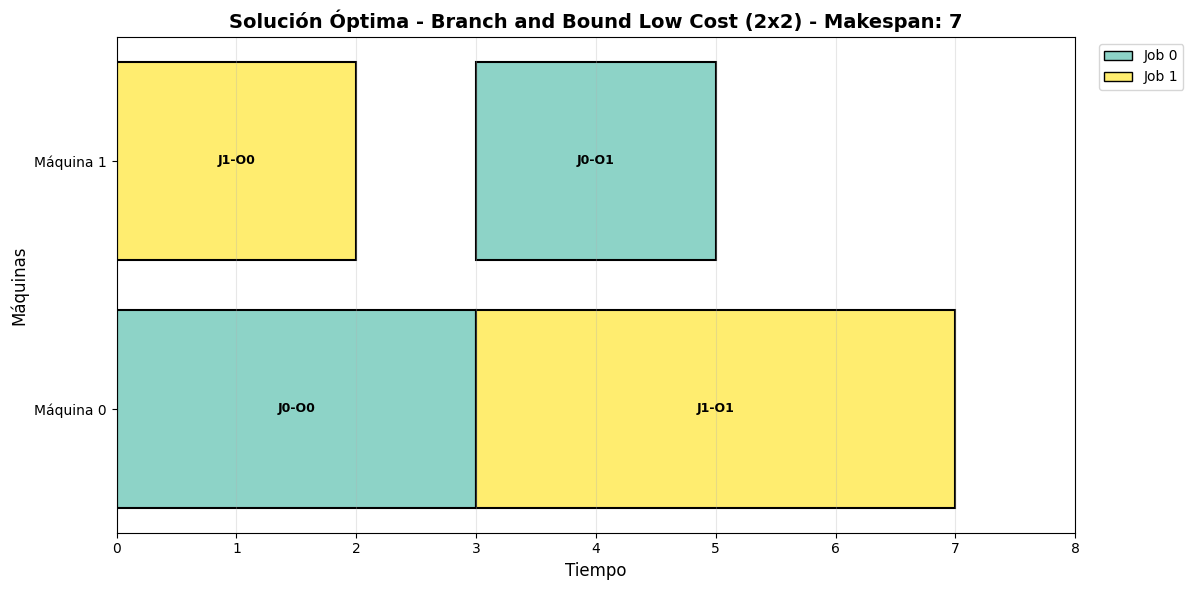

In [26]:
print("=" * 60)
print("PROBLEMA 3x3")
print("=" * 60)
print("\\nDefinición del problema:")
for i, job in enumerate(problema_test):
    print(f"  Job {i}: {job}")

# Resolver con Branch and Bound Low Cost
print("\\n" + "-" * 60)
print("Resolviendo con Branch and Bound Low Cost...")
print("-" * 60)

solver = BranchAndBoundLIFO(problema_test, verbose=True, tipo_cota="maquinas_independientes")
makespan_optimo, solucion_optima = solver.resolver()

print("\\n" + "=" * 60)
print("SOLUCIÓN ÓPTIMA ENCONTRADA")
print("=" * 60)
print(f"Makespan óptimo: {makespan_optimo}")
print(f"Nodos explorados: {solver.nodos_explorados}")
print(f"Nodos podados: {solver.nodos_podados}")
print(f"Eficiencia de poda: {100 * solver.nodos_podados / max(1, solver.nodos_explorados + solver.nodos_podados):.1f}%")
print(f"Tiempo de ejecución: {solver.tiempo_ejecucion:.4f}s")

visualizar_gantt(solucion_optima, "Solución Óptima - Branch and Bound Low Cost (2x2)")


## Ejemplo 1: Problema 3x3

Resolvemos el problema más pequeño (3 jobs, 3 máquinas) y visualizamos la solución.


In [27]:
print("=" * 60)
print("PROBLEMA 3x3")
print("=" * 60)
print("\\nDefinición del problema:")
for i, job in enumerate(problema_3x3):
    print(f"  Job {i}: {job}")

# Resolver con Branch and Bound Low Cost
print("\\n" + "-" * 60)
print("Resolviendo con Branch and Bound Low Cost...")
print("-" * 60)

solver = BranchAndBoundLowCost(problema_3x3, verbose=True)
makespan_optimo, solucion_optima = solver.resolver()

print("\\n" + "=" * 60)
print("SOLUCIÓN ÓPTIMA ENCONTRADA")
print("=" * 60)
print(f"Makespan óptimo: {makespan_optimo}")
print(f"Nodos explorados: {solver.nodos_explorados}")
print(f"Nodos podados: {solver.nodos_podados}")
print(f"Eficiencia de poda: {100 * solver.nodos_podados / max(1, solver.nodos_explorados + solver.nodos_podados):.1f}%")
print(f"Tiempo de ejecución: {solver.tiempo_ejecucion:.4f}s")


PROBLEMA 3x3
\nDefinición del problema:
  Job 0: [(0, 3), (1, 2), (2, 2)]
  Job 1: [(0, 2), (2, 1), (1, 4)]
  Job 2: [(1, 4), (2, 3), (0, 1)]
\n------------------------------------------------------------
Resolviendo con Branch and Bound Low Cost...
------------------------------------------------------------
Cota superior inicial: 20
Nueva mejor solución: 11 (nodos: 103)

=== Estadísticas ===
Makespan óptimo: 11
Nodos explorados: 241
Nodos podados: 138
Tiempo: 0.0122s
\n============================================================
SOLUCIÓN ÓPTIMA ENCONTRADA
Makespan óptimo: 11
Nodos explorados: 241
Nodos podados: 138
Eficiencia de poda: 36.4%
Tiempo de ejecución: 0.0122s


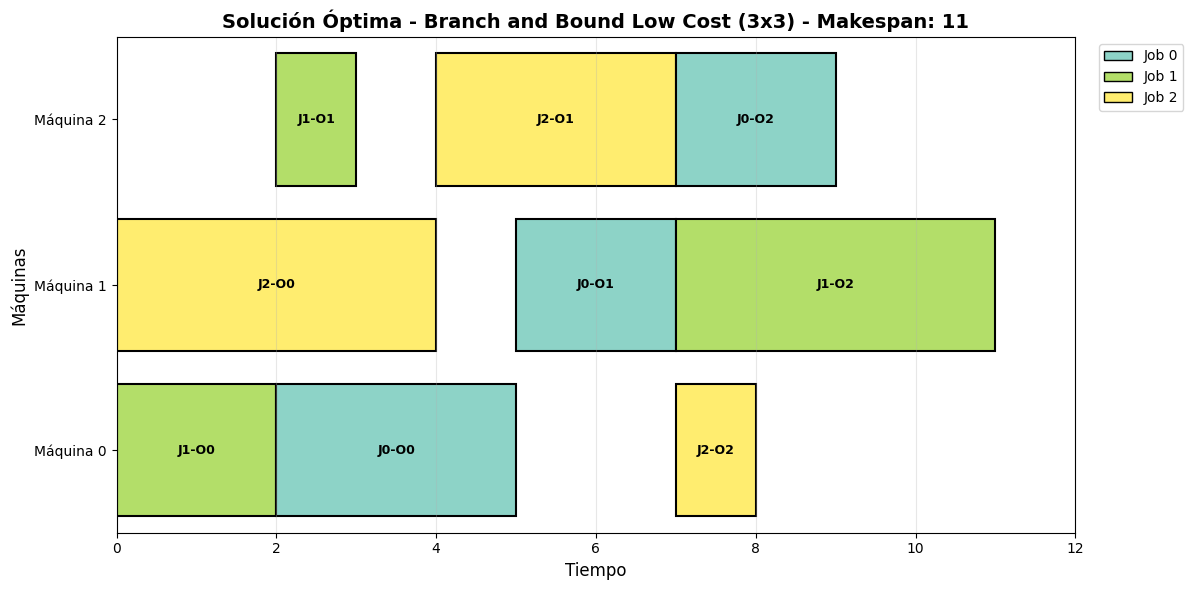

In [28]:
# Visualizar solución óptima
visualizar_gantt(solucion_optima, "Solución Óptima - Branch and Bound Low Cost (3x3)")


## Comparación entre Estrategias de Branch and Bound

Comparemos las tres estrategias de Branch and Bound: Low Cost, LIFO y FIFO.


Comparando estrategias de Branch and Bound (3x3):
PODADO
PODADO
PODADO
PODADO
PODADO
Estrategia             Makespan  Nodos Expl.  Nodos Podados    Tiempo(s)
--------------------------------------------------------------------------------
Low Cost (heap)              11          241            138       0.0122
LIFO (DFS)                   11          133            125       0.0110
FIFO (BFS)                   11         5112           1668       0.1738
\nObservaciones:
  - Todas las estrategias encuentran el óptimo: 11
  - Low Cost exploró: 241 nodos
  - LIFO exploró: 133 nodos (55.2% vs Low Cost)
  - FIFO exploró: 5112 nodos (2121.2% vs Low Cost)


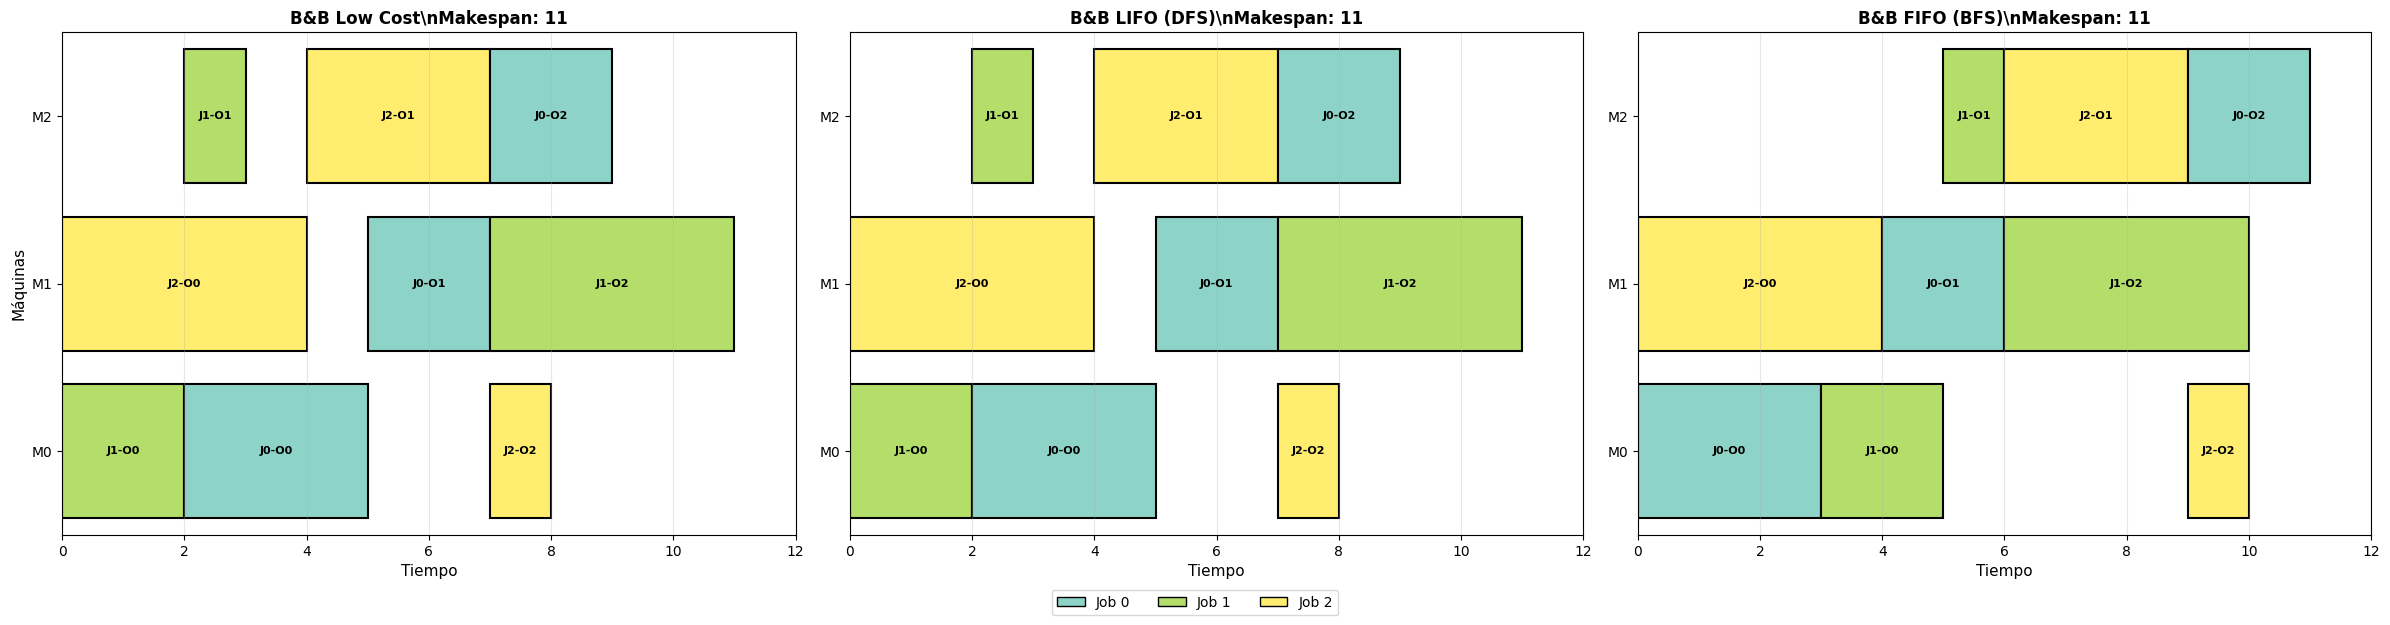

In [29]:
# Resolver con las tres estrategias
print("Comparando estrategias de Branch and Bound (3x3):")
print("=" * 80)

solver_lifo = BranchAndBoundLIFO(problema_3x3, verbose=False)
makespan_lifo, solucion_lifo = solver_lifo.resolver()

solver_fifo = BranchAndBoundFIFO(problema_3x3, verbose=False)
makespan_fifo, solucion_fifo = solver_fifo.resolver()

print(f"{'Estrategia':<20} {'Makespan':>10} {'Nodos Expl.':>12} {'Nodos Podados':>14} {'Tiempo(s)':>12}")
print("-" * 80)
print(f"{'Low Cost (heap)':<20} {makespan_optimo:>10} {solver.nodos_explorados:>12} {solver.nodos_podados:>14} {solver.tiempo_ejecucion:>12.4f}")
print(f"{'LIFO (DFS)':<20} {makespan_lifo:>10} {solver_lifo.nodos_explorados:>12} {solver_lifo.nodos_podados:>14} {solver_lifo.tiempo_ejecucion:>12.4f}")
print(f"{'FIFO (BFS)':<20} {makespan_fifo:>10} {solver_fifo.nodos_explorados:>12} {solver_fifo.nodos_podados:>14} {solver_fifo.tiempo_ejecucion:>12.4f}")
print("=" * 80)

print("\\nObservaciones:")
print(f"  - Todas las estrategias encuentran el óptimo: {makespan_optimo}")
print(f"  - Low Cost exploró: {solver.nodos_explorados} nodos")
print(f"  - LIFO exploró: {solver_lifo.nodos_explorados} nodos ({100*solver_lifo.nodos_explorados/solver.nodos_explorados:.1f}% vs Low Cost)")
print(f"  - FIFO exploró: {solver_fifo.nodos_explorados} nodos ({100*solver_fifo.nodos_explorados/solver.nodos_explorados:.1f}% vs Low Cost)")

# Visualizar comparación
comparar_soluciones_gantt([
    ("B&B Low Cost", solucion_optima),
    ("B&B LIFO (DFS)", solucion_lifo),
    ("B&B FIFO (BFS)", solucion_fifo)
])


## Ejemplo 2: Problema 4x3

Ahora probamos con un problema un poco más grande.


In [30]:
print("=" * 60)
print("PROBLEMA 4x3")
print("=" * 60)
print("\\nDefinición del problema:")
for i, job in enumerate(problema_4x3):
    print(f"  Job {i}: {job}")

# Resolver
print("\\nResolviendo...")
solver_4x3 = BranchAndBoundLowCost(problema_4x3, verbose=True)
makespan_optimo_4x3, solucion_optima_4x3 = solver_4x3.resolver()

print(f"\\nEficiencia de poda: {100 * solver_4x3.nodos_podados / max(1, solver_4x3.nodos_explorados + solver_4x3.nodos_podados):.1f}%")


PROBLEMA 4x3
\nDefinición del problema:
  Job 0: [(0, 2), (1, 3), (2, 1)]
  Job 1: [(1, 2), (0, 4), (2, 2)]
  Job 2: [(2, 3), (0, 1), (1, 2)]
  Job 3: [(0, 2), (2, 2), (1, 3)]
\nResolviendo...
Cota superior inicial: 24
Nueva mejor solución: 11 (nodos: 49)

=== Estadísticas ===
Makespan óptimo: 11
Nodos explorados: 157
Nodos podados: 108
Tiempo: 0.0099s
\nEficiencia de poda: 40.8%


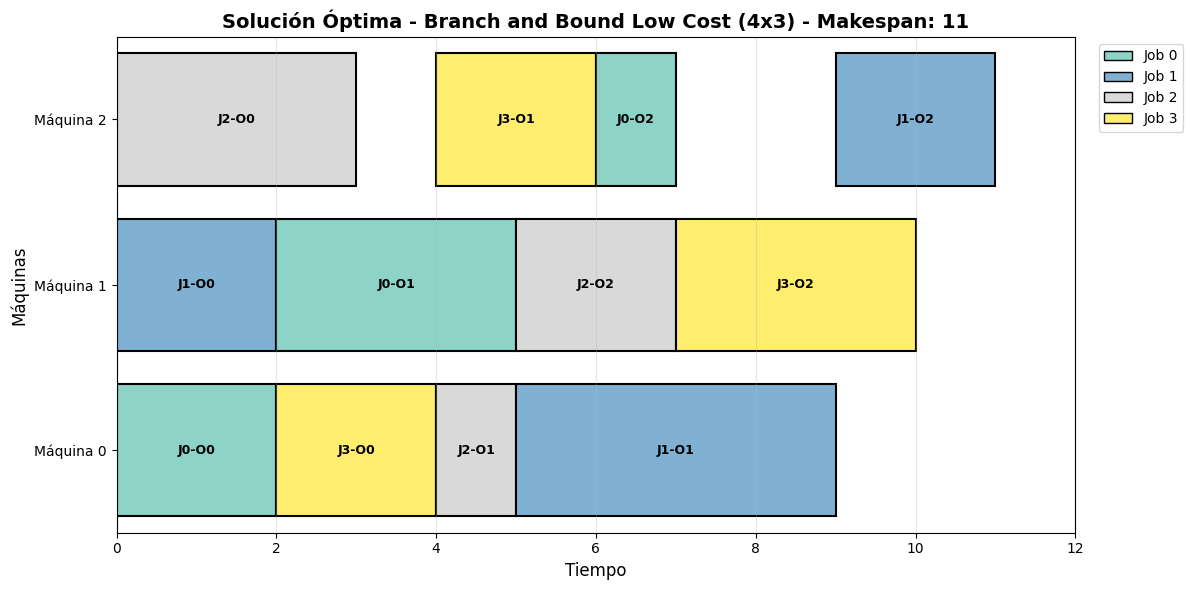

In [31]:
# Visualizar
visualizar_gantt(solucion_optima_4x3, "Solución Óptima - Branch and Bound Low Cost (4x3)")


PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
Comparación de Estrategias B&B (4x3):
Estrategia             Makespan  Nodos Expl.  Nodos Podados    Tiempo(s)
--------------------------------------------------------------------------------
Low Cost                     11          157            108       0.0099
LIFO (DFS)                   11          267            497       0.0376
FIFO (BFS)                   11      1103371         369083      27.9134


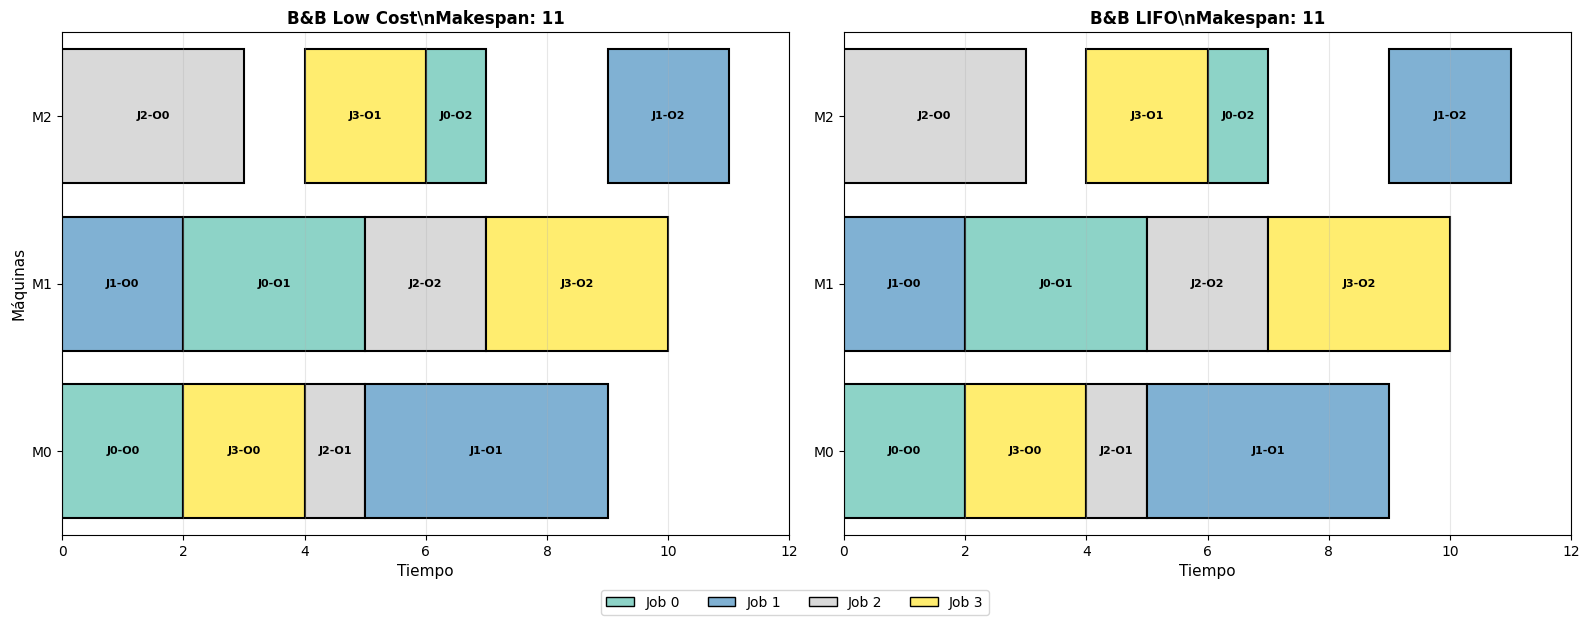

In [32]:
# Comparación entre estrategias
solver_lifo_4x3 = BranchAndBoundLIFO(problema_4x3, verbose=False)
makespan_lifo_4x3, solucion_lifo_4x3 = solver_lifo_4x3.resolver()

solver_fifo_4x3 = BranchAndBoundFIFO(problema_4x3, verbose=False)
makespan_fifo_4x3, solucion_fifo_4x3 = solver_fifo_4x3.resolver()

print("Comparación de Estrategias B&B (4x3):")
print("=" * 80)
print(f"{'Estrategia':<20} {'Makespan':>10} {'Nodos Expl.':>12} {'Nodos Podados':>14} {'Tiempo(s)':>12}")
print("-" * 80)
print(f"{'Low Cost':<20} {makespan_optimo_4x3:>10} {solver_4x3.nodos_explorados:>12} {solver_4x3.nodos_podados:>14} {solver_4x3.tiempo_ejecucion:>12.4f}")
print(f"{'LIFO (DFS)':<20} {makespan_lifo_4x3:>10} {solver_lifo_4x3.nodos_explorados:>12} {solver_lifo_4x3.nodos_podados:>14} {solver_lifo_4x3.tiempo_ejecucion:>12.4f}")
print(f"{'FIFO (BFS)':<20} {makespan_fifo_4x3:>10} {solver_fifo_4x3.nodos_explorados:>12} {solver_fifo_4x3.nodos_podados:>14} {solver_fifo_4x3.tiempo_ejecucion:>12.4f}")
print("=" * 80)

comparar_soluciones_gantt([
    ("B&B Low Cost", solucion_optima_4x3),
    ("B&B LIFO", solucion_lifo_4x3)
])


## Análisis de Complejidad y Eficiencia

Analicemos cómo crece el número de nodos explorados con el tamaño del problema.


In [33]:
# Generar problemas de diferentes tamaños
def generar_problema_aleatorio(num_jobs: int, num_maquinas: int, seed: int = 42) -> List[List[Tuple[int, int]]]:
    """Genera un problema JSSP aleatorio.
    
    Args:
        num_jobs: Número de jobs
        num_maquinas: Número de máquinas
        seed: Semilla para reproducibilidad
        
    Returns:
        Problema JSSP
    """
    np.random.seed(seed)
    problema = []
    
    for _ in range(num_jobs):
        # Cada job visita cada máquina una vez en orden aleatorio
        maquinas = np.random.permutation(num_maquinas)
        duraciones = np.random.randint(1, 6, size=num_maquinas)  # Duraciones entre 1 y 5
        job = list(zip(maquinas.tolist(), duraciones.tolist()))
        problema.append(job)
    
    return problema


# Ejecutar experimentos
configuraciones = [
    (2, 2),
    (3, 3),
    (4, 3),
    (4, 4),
]

resultados = []

print("Ejecutando experimentos de complejidad...\\n")
print(f"{'Jobs':>5} {'Máqs':>5} {'Makespan':>10} {'Nodos':>10} {'Podados':>10} {'Tiempo(s)':>10}")
print("=" * 65)

for num_jobs, num_maquinas in configuraciones:
    problema = generar_problema_aleatorio(num_jobs, num_maquinas)
    solver = BranchAndBoundLowCost(problema, verbose=False)
    makespan, _ = solver.resolver()
    
    resultados.append({
        'jobs': num_jobs,
        'maquinas': num_maquinas,
        'makespan': makespan,
        'nodos': solver.nodos_explorados,
        'podados': solver.nodos_podados,
        'tiempo': solver.tiempo_ejecucion
    })
    
    print(f"{num_jobs:>5} {num_maquinas:>5} {makespan:>10} {solver.nodos_explorados:>10} {solver.nodos_podados:>10} {solver.tiempo_ejecucion:>10.4f}")

print("\n✓ Experimentos completados")


Ejecutando experimentos de complejidad...\n
 Jobs  Máqs   Makespan      Nodos    Podados  Tiempo(s)
    2     2         13         10          5     0.0003
    3     3         17        181        102     0.0033
    4     3         18       3010       1888     0.0908
    4     4         21     289979     184365     7.1938

✓ Experimentos completados


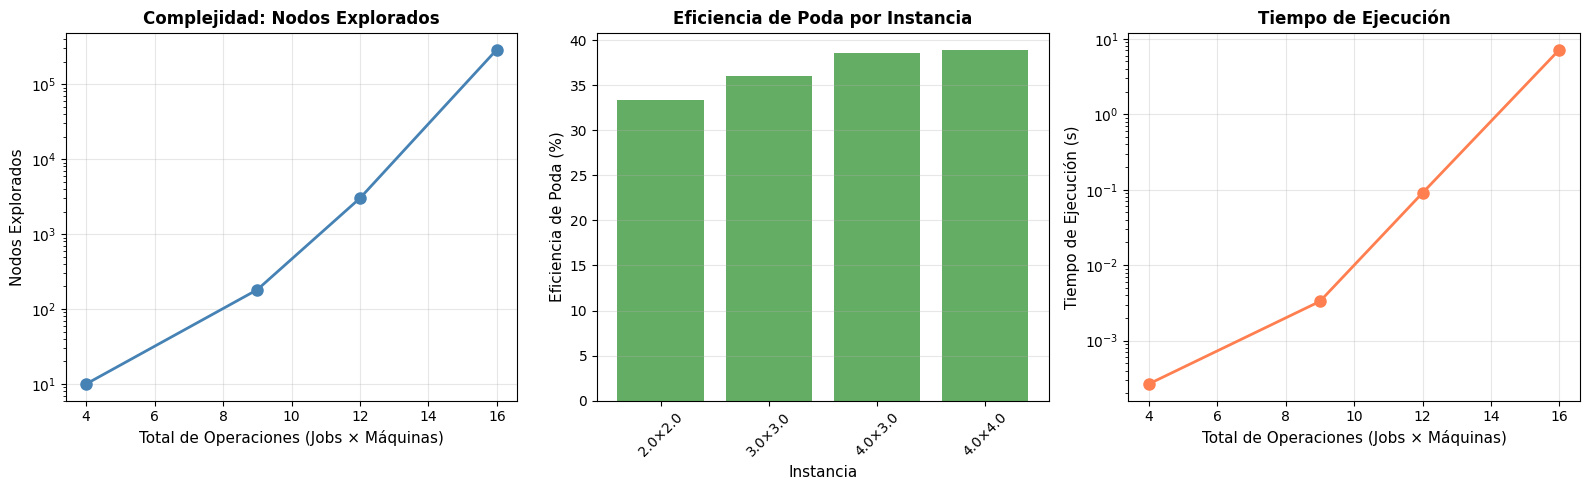

\n✓ Gráficos de análisis generados


In [34]:
# Visualizar resultados
df = pd.DataFrame(resultados)
df['total_operaciones'] = df['jobs'] * df['maquinas']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: Nodos explorados vs tamaño del problema
ax1 = axes[0]
ax1.plot(df['total_operaciones'], df['nodos'], 'o-', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('Total de Operaciones (Jobs × Máquinas)', fontsize=11)
ax1.set_ylabel('Nodos Explorados', fontsize=11)
ax1.set_title('Complejidad: Nodos Explorados', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Gráfico 2: Eficiencia de poda
ax2 = axes[1]
df['eficiencia_poda'] = 100 * df['podados'] / (df['nodos'] + df['podados'])
ax2.bar(range(len(df)), df['eficiencia_poda'], color='forestgreen', alpha=0.7)
ax2.set_xlabel('Instancia', fontsize=11)
ax2.set_ylabel('Eficiencia de Poda (%)', fontsize=11)
ax2.set_title('Eficiencia de Poda por Instancia', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(df)))
ax2.set_xticklabels([f"{r['jobs']}×{r['maquinas']}" for _, r in df.iterrows()], rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Gráfico 3: Tiempo de ejecución
ax3 = axes[2]
ax3.plot(df['total_operaciones'], df['tiempo'], 'o-', linewidth=2, markersize=8, color='coral')
ax3.set_xlabel('Total de Operaciones (Jobs × Máquinas)', fontsize=11)
ax3.set_ylabel('Tiempo de Ejecución (s)', fontsize=11)
ax3.set_title('Tiempo de Ejecución', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

plt.tight_layout()
plt.show()

print("\\n✓ Gráficos de análisis generados")


## Tabla Comparativa: Low Cost vs LIFO vs FIFO


Ejecutando comparación de estrategias B&B...
  2×2: Makespan=13, LC=10n, LIFO=8n, FIFO=10n


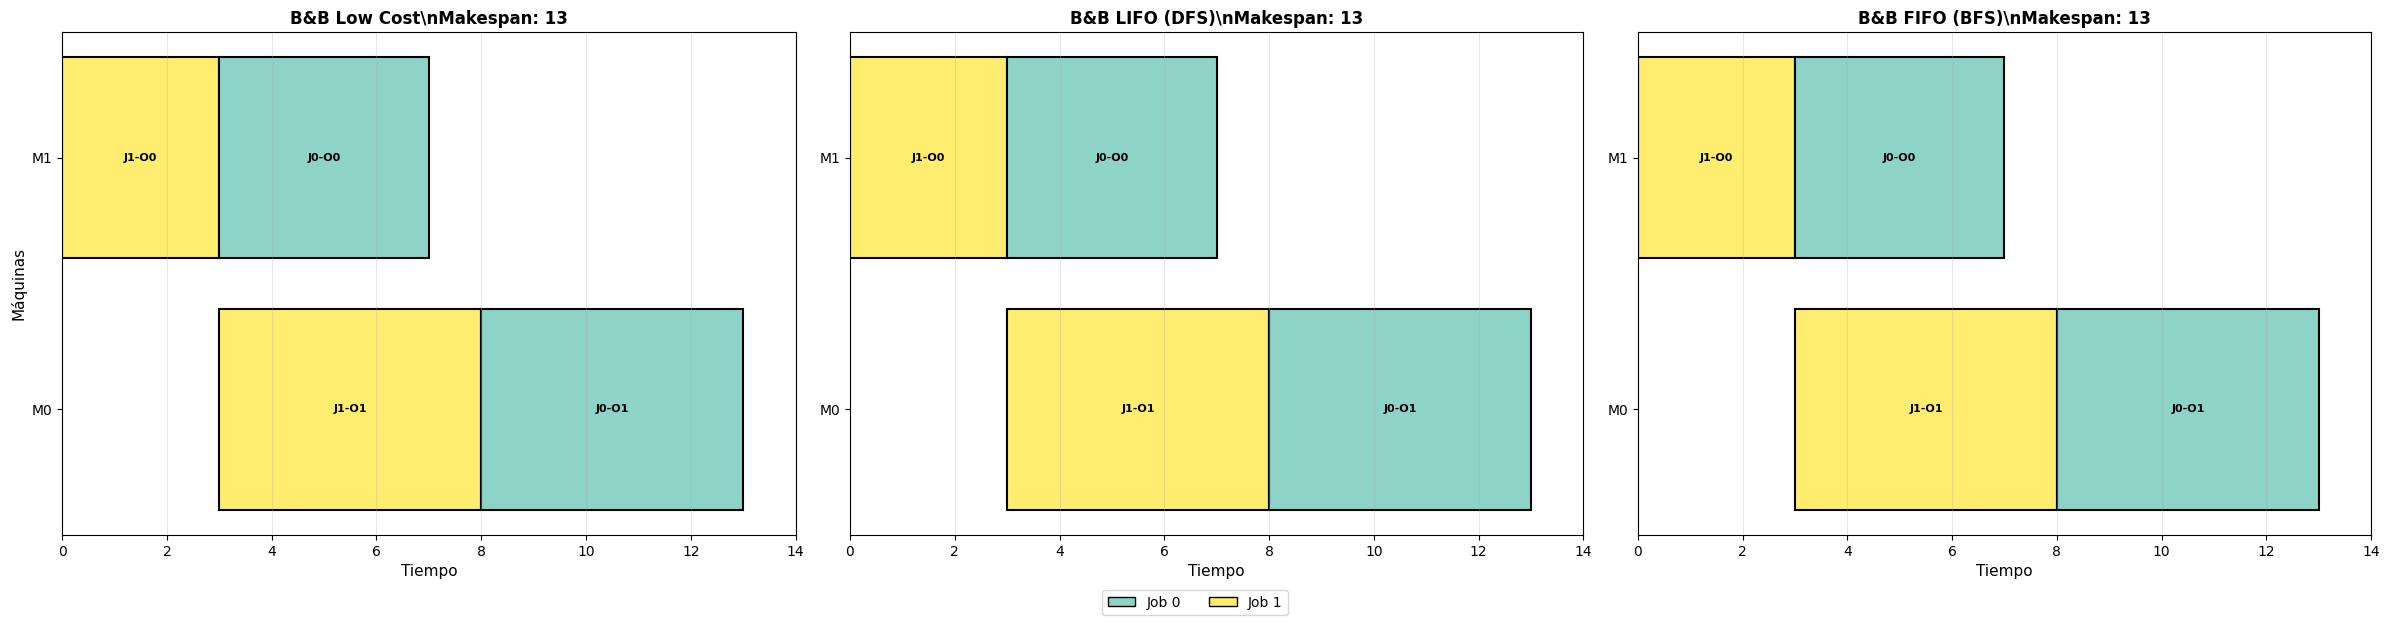

PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
  3×3: Makespan=17, LC=181n, LIFO=97n, FIFO=5174n


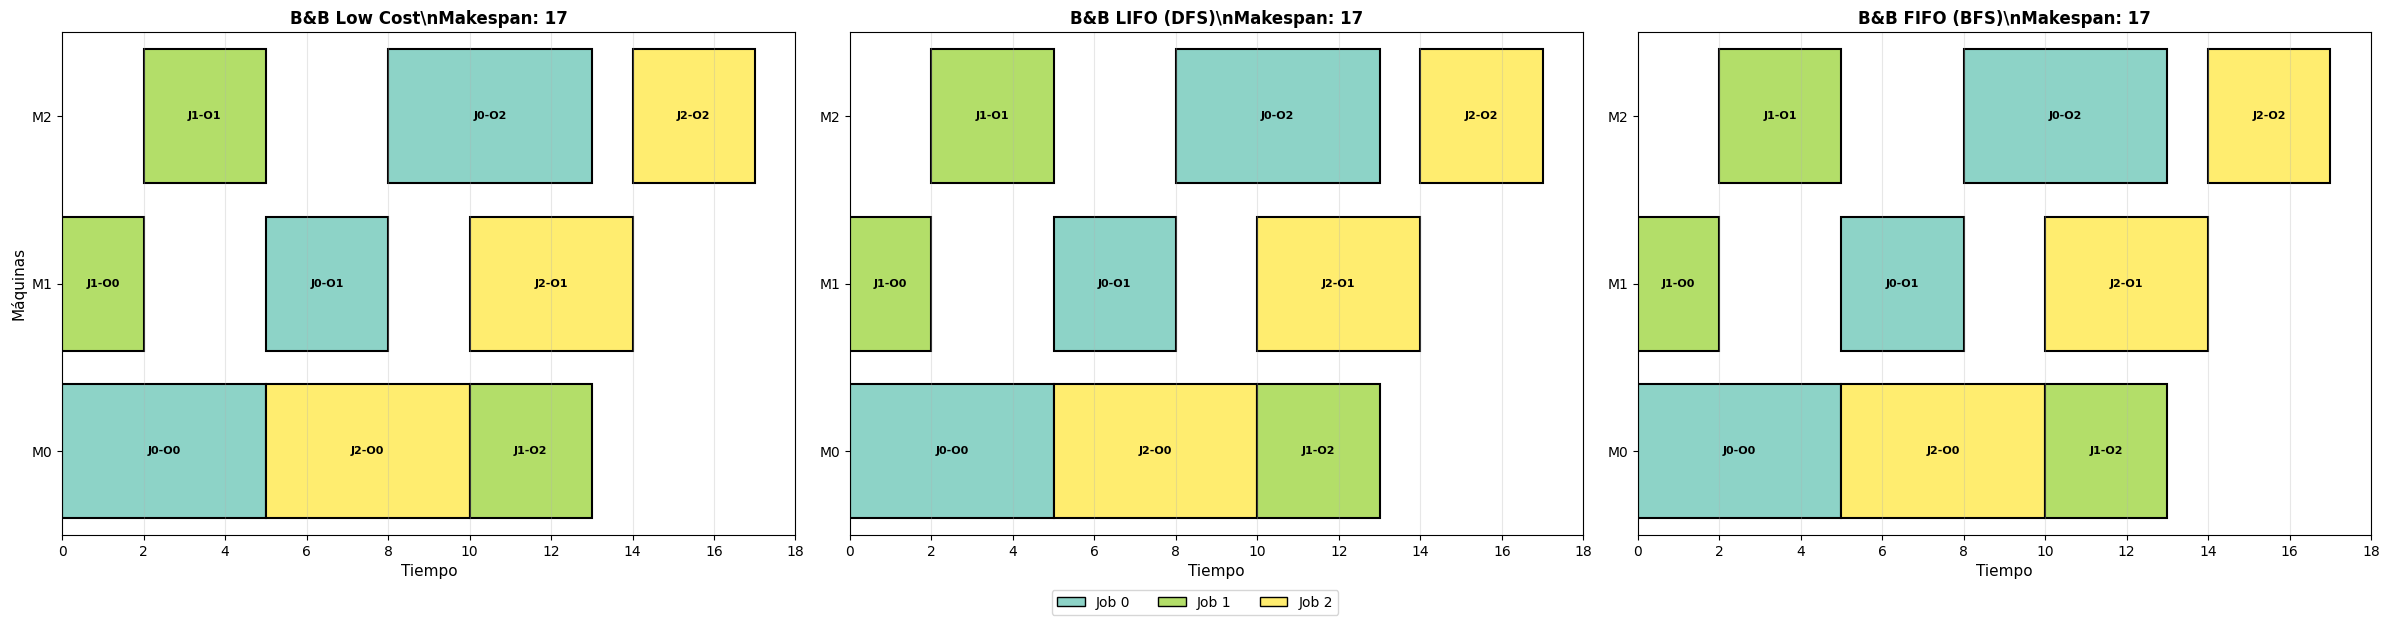

PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
  4×3: Makespan=18, LC=3010n, LIFO=689n, FIFO=1106857n


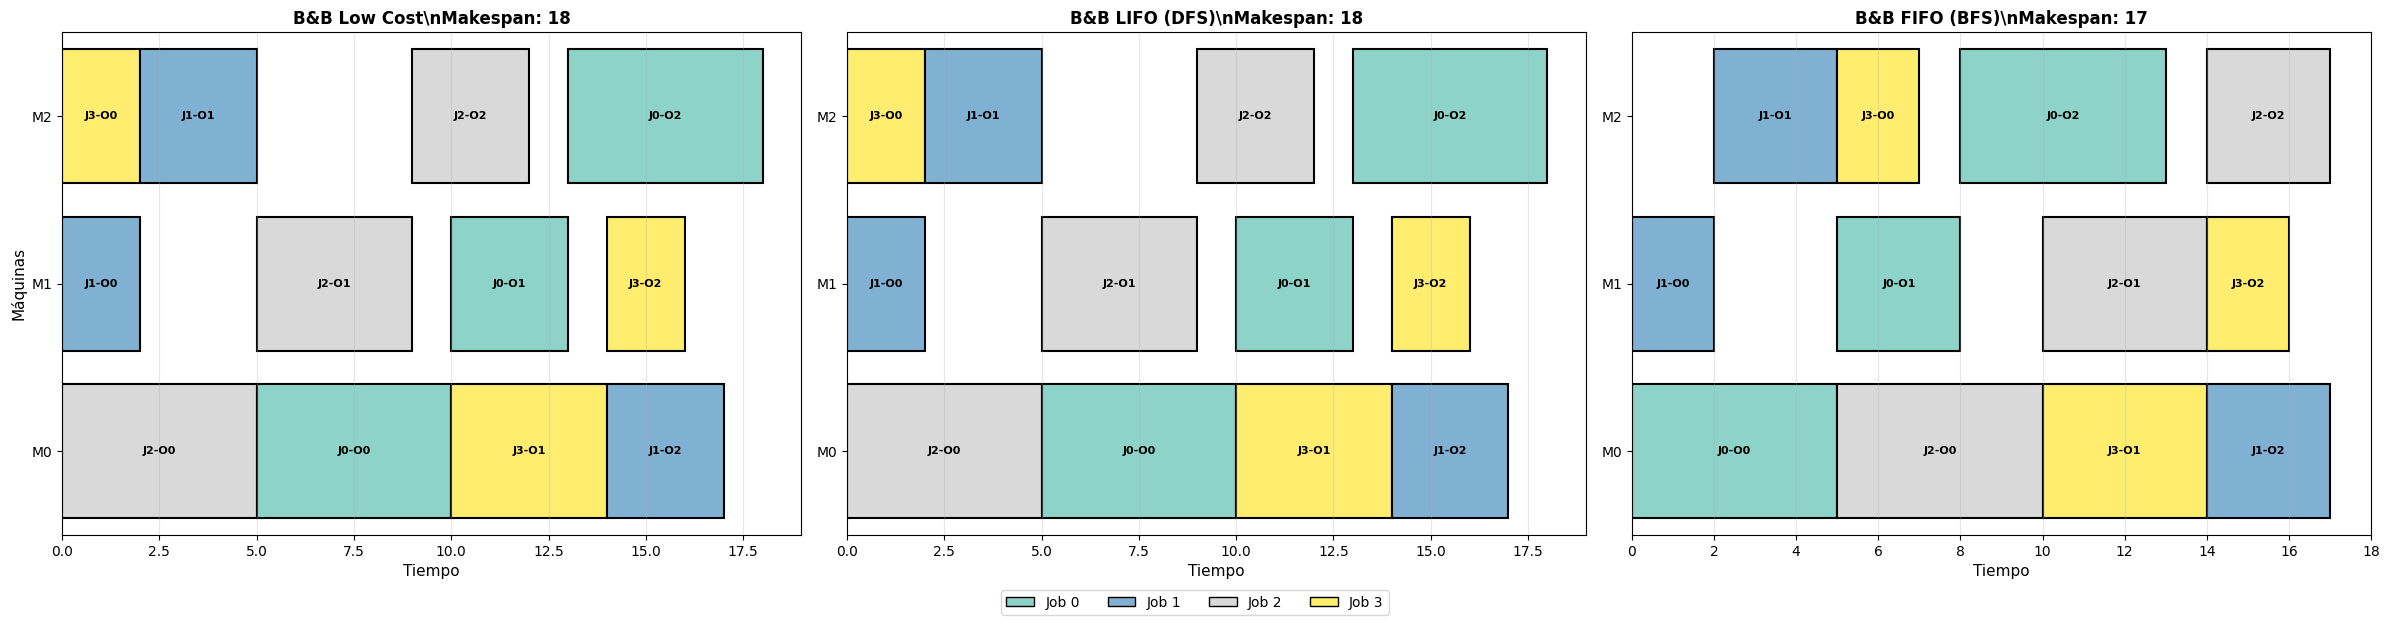

PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
PODADO
  4×4: Makespan=21, LC=289979n, LIFO=165865n, FIFO=2000000n


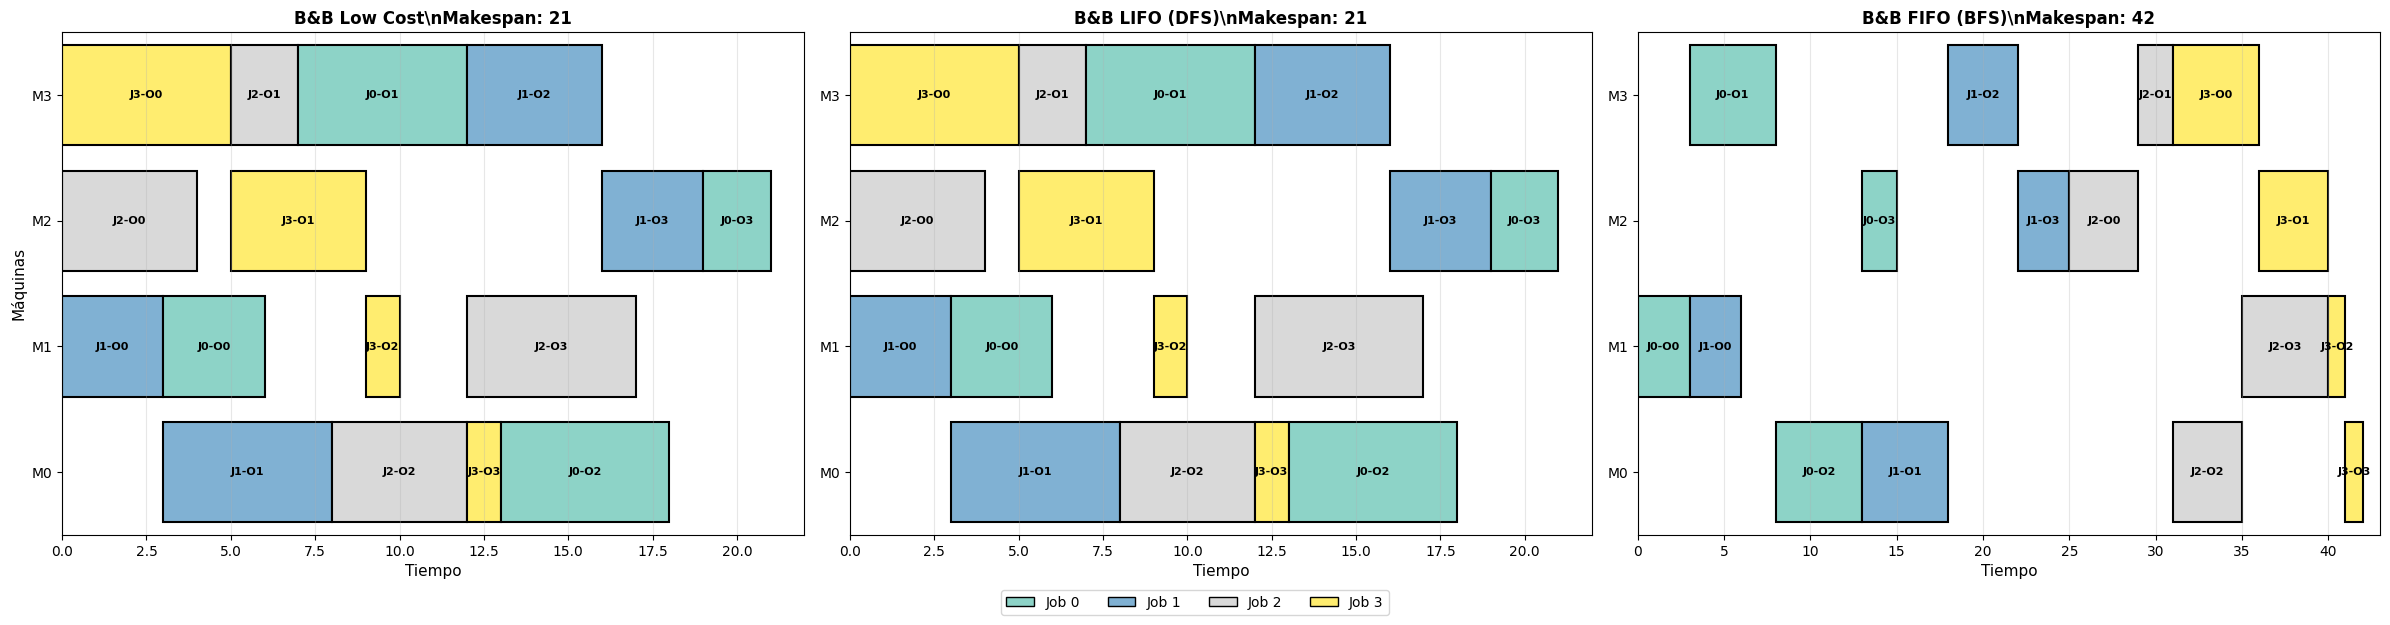

\n==============================================================================================================
COMPARACIÓN: Branch & Bound - Low Cost vs LIFO vs FIFO
Instancia      Makespan |   LC Nodos    LC Tiempo |   LIFO Nodos  LIFO Tiempo |   FIFO Nodos  FIFO Tiempo
--------------------------------------------------------------------------------------------------------------
2×2                  13 |         10       0.0003 |            8       0.0002 |           10       0.0002
3×3                  17 |        181       0.0022 |           97       0.0028 |         5174       0.0793
4×3                  18 |       3010       0.0657 |          689       0.0242 |      1106857      19.7636
4×4                  21 |     289979       6.6694 |       165865       7.8042 |      2000000     217.9292
\n📊 Estadísticas Globales:
  Low Cost  - Nodos promedio: 73295, Tiempo promedio: 1.6844s
  LIFO (DFS) - Nodos promedio: 41665, Tiempo promedio: 1.9579s
  FIFO (BFS) - Nodos promedio: 778010, 

In [35]:
# Comparar las tres estrategias de Branch and Bound en múltiples instancias
comparacion_resultados = []

print("Ejecutando comparación de estrategias B&B...")
for num_jobs, num_maquinas in configuraciones:
    problema = generar_problema_aleatorio(num_jobs, num_maquinas)
    
    # Low Cost
    solver_lc = BranchAndBoundLowCost(problema, verbose=False)
    makespan_lc, s1 = solver_lc.resolver()
    
    # LIFO
    solver_lifo = BranchAndBoundLIFO(problema, verbose=False)
    makespan_lifo, s2 = solver_lifo.resolver()
    
    # FIFO
    solver_fifo = BranchAndBoundFIFO(problema, verbose=False)
    makespan_fifo, s3 = solver_fifo.resolver()
    
    comparacion_resultados.append({
        'Instancia': f"{num_jobs}×{num_maquinas}",
        'Makespan': makespan_lc,  # Todos dan el mismo (óptimo)
        'LC_Nodos': solver_lc.nodos_explorados,
        'LC_Tiempo': solver_lc.tiempo_ejecucion,
        'LIFO_Nodos': solver_lifo.nodos_explorados,
        'LIFO_Tiempo': solver_lifo.tiempo_ejecucion,
        'FIFO_Nodos': solver_fifo.nodos_explorados,
        'FIFO_Tiempo': solver_fifo.tiempo_ejecucion,
    })
    print(f"  {num_jobs}×{num_maquinas}: Makespan={makespan_lc}, LC={solver_lc.nodos_explorados}n, LIFO={solver_lifo.nodos_explorados}n, FIFO={solver_fifo.nodos_explorados}n")
    comparar_soluciones_gantt([
        ("B&B Low Cost", s1),
        ("B&B LIFO (DFS)", s2),
        ("B&B FIFO (BFS)", s3)
    ])

df_comparacion = pd.DataFrame(comparacion_resultados)

print("\\n" + "=" * 110)
print("COMPARACIÓN: Branch & Bound - Low Cost vs LIFO vs FIFO")
print("=" * 110)
print(f"{'Instancia':<12} {'Makespan':>10} | {'LC Nodos':>10} {'LC Tiempo':>12} | {'LIFO Nodos':>12} {'LIFO Tiempo':>12} | {'FIFO Nodos':>12} {'FIFO Tiempo':>12}")
print("-" * 110)
for _, row in df_comparacion.iterrows():
    print(f"{row['Instancia']:<12} {row['Makespan']:>10} | {row['LC_Nodos']:>10} {row['LC_Tiempo']:>12.4f} | {row['LIFO_Nodos']:>12} {row['LIFO_Tiempo']:>12.4f} | {row['FIFO_Nodos']:>12} {row['FIFO_Tiempo']:>12.4f}")
print("=" * 110)

print("\\n📊 Estadísticas Globales:")
print(f"  Low Cost  - Nodos promedio: {df_comparacion['LC_Nodos'].mean():.0f}, Tiempo promedio: {df_comparacion['LC_Tiempo'].mean():.4f}s")
print(f"  LIFO (DFS) - Nodos promedio: {df_comparacion['LIFO_Nodos'].mean():.0f}, Tiempo promedio: {df_comparacion['LIFO_Tiempo'].mean():.4f}s")
print(f"  FIFO (BFS) - Nodos promedio: {df_comparacion['FIFO_Nodos'].mean():.0f}, Tiempo promedio: {df_comparacion['FIFO_Tiempo'].mean():.4f}s")
print("\\n✓ Observación: Todas las estrategias encuentran el óptimo, pero con diferente eficiencia")


## Visualización Comparativa: Nodos Explorados y Tiempos


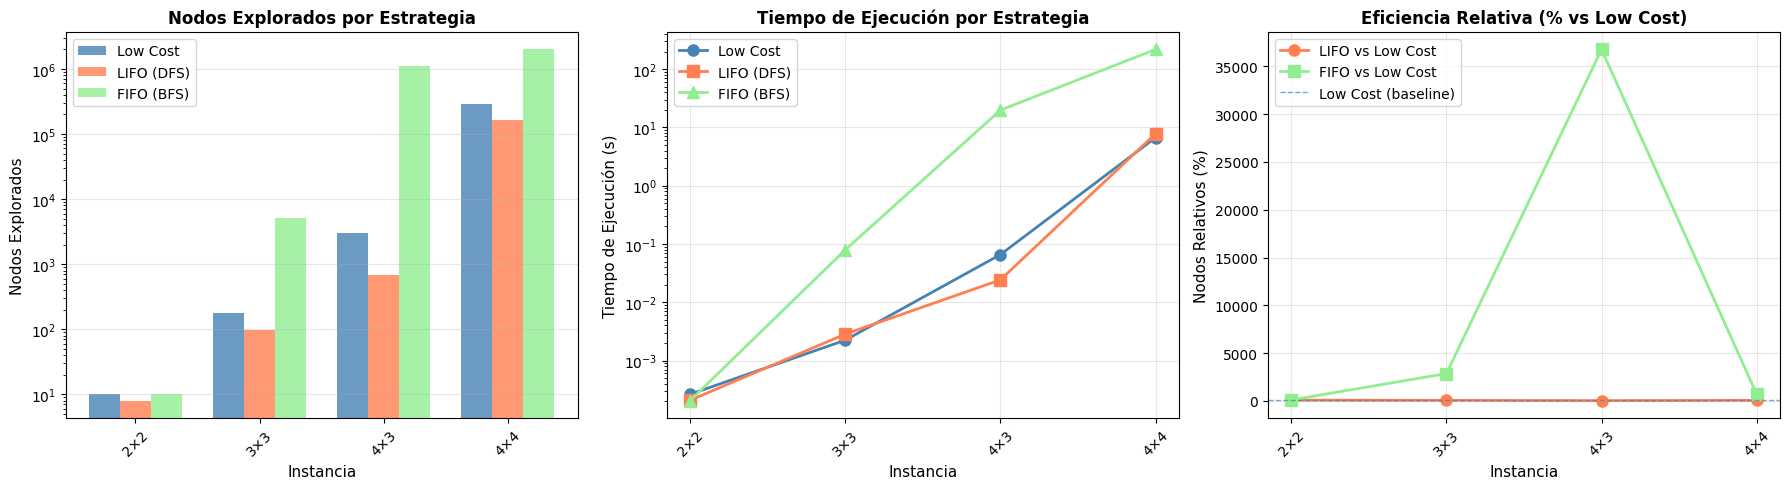

\n📈 Interpretación:
  - Low Cost suele explorar MENOS nodos (usa información de la cota)
  - LIFO puede ser más rápido en encontrar una solución, pero explora más nodos
  - FIFO explora sistemáticamente, útil para garantizar exploración exhaustiva


In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

instancias = df_comparacion['Instancia'].tolist()
x = np.arange(len(instancias))
width = 0.25

# Gráfico 1: Comparación de Nodos Explorados
ax1 = axes[0]
ax1.bar(x - width, df_comparacion['LC_Nodos'], width, label='Low Cost', color='steelblue', alpha=0.8)
ax1.bar(x, df_comparacion['LIFO_Nodos'], width, label='LIFO (DFS)', color='coral', alpha=0.8)
ax1.bar(x + width, df_comparacion['FIFO_Nodos'], width, label='FIFO (BFS)', color='lightgreen', alpha=0.8)
ax1.set_xlabel('Instancia', fontsize=11)
ax1.set_ylabel('Nodos Explorados', fontsize=11)
ax1.set_title('Nodos Explorados por Estrategia', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(instancias, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_yscale('log')

# Gráfico 2: Comparación de Tiempos
ax2 = axes[1]
ax2.plot(instancias, df_comparacion['LC_Tiempo'], 'o-', label='Low Cost', linewidth=2, markersize=8, color='steelblue')
ax2.plot(instancias, df_comparacion['LIFO_Tiempo'], 's-', label='LIFO (DFS)', linewidth=2, markersize=8, color='coral')
ax2.plot(instancias, df_comparacion['FIFO_Tiempo'], '^-', label='FIFO (BFS)', linewidth=2, markersize=8, color='lightgreen')
ax2.set_xlabel('Instancia', fontsize=11)
ax2.set_ylabel('Tiempo de Ejecución (s)', fontsize=11)
ax2.set_title('Tiempo de Ejecución por Estrategia', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Gráfico 3: Eficiencia Relativa (nodos explorados relativos a Low Cost)
ax3 = axes[2]
eficiencia_lifo = 100 * df_comparacion['LIFO_Nodos'] / df_comparacion['LC_Nodos']
eficiencia_fifo = 100 * df_comparacion['FIFO_Nodos'] / df_comparacion['LC_Nodos']
ax3.plot(instancias, eficiencia_lifo, 'o-', label='LIFO vs Low Cost', linewidth=2, markersize=8, color='coral')
ax3.plot(instancias, eficiencia_fifo, 's-', label='FIFO vs Low Cost', linewidth=2, markersize=8, color='lightgreen')
ax3.axhline(y=100, color='steelblue', linestyle='--', linewidth=1, alpha=0.7, label='Low Cost (baseline)')
ax3.set_xlabel('Instancia', fontsize=11)
ax3.set_ylabel('Nodos Relativos (%)', fontsize=11)
ax3.set_title('Eficiencia Relativa (% vs Low Cost)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\\n📈 Interpretación:")
print(f"  - Low Cost suele explorar MENOS nodos (usa información de la cota)")
print(f"  - LIFO puede ser más rápido en encontrar una solución, pero explora más nodos")
print(f"  - FIFO explora sistemáticamente, útil para garantizar exploración exhaustiva")


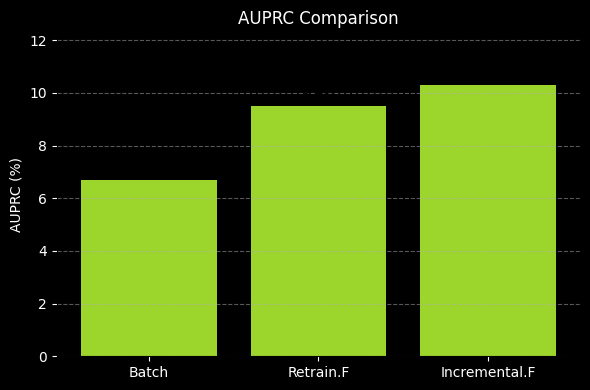

In [ ]:
# Bar chart for AUPRC comparison (Batch vs Incremental)
import matplotlib.pyplot as plt

# Data from the paper
methods = ["Batch", "Retrain.F","Incremental.F"]
auprc = [6.7, 9.5, 10.3]  # percentages

# Create the bar chart
fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor("black")      # Fondo negro de la figura
ax.set_facecolor("black") 
bars = ax.bar(methods, auprc, color="#9cd52c")

# Annotate bars with values
for bar, value in zip(bars, auprc):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f"{value:.1f}%", 
            ha="center", va="bottom")

# Axis labels and title
ax.set_ylabel("AUPRC (%)", color="white")
ax.set_title("AUPRC Comparison", color="white")
ax.set_ylim(0, max(auprc) + 2)
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.tick_params(colors="white")  # Cambia color de los ejes a blanco

plt.tight_layout()
plt.show()
